# Arrival Time Prediction - Synchronisation
This notebook is the third on the work on GP regression for arrival time prediction. The goal of this one is to estimate a function for each segment that synchonises the progress of all trajectories. This needs to be done so that predictions can be made based on a new trajectory and not a single data point.

The synchonisation function will be estimated using a GP, which we are all familiar now by now. First off, let's get some libraries into scope, set the seed and load the data that was pickled in the first notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats 
import math
import tensorflow as tf
import plot
import GPy
import gp_gpy as gp

train = pd.read_pickle('train.pkl')
support = pd.read_pickle('support.pkl')
route_n = 3
traj_n = 7
sns.set(style="darkgrid")
np.random.seed(1)

## Hyperparameter Priors
The synchronisation function is a function $f : \mathcal{R}^2 \mapsto [0, 1]$ so we will use a bivariate GP model. Let's look at some priors for the hyperparameters kernel lengthscale, kernel variance and likelihood variance. We will not use this in the conventional sense of learning parameters using MAP (Maximum aposteriori), but for performing random restarts while learning using ML (Maximum likelihood). This needs to be done since GPs are quite prone to getting stuck in local minimas. Let's start with the kernel lengthscale parameter.

### Kernel Lenghtscale ($l$)
When the data was downsampled in the pre processing, it was done with $\delta = 3*10^{-2}$. Based on this we have implicitly said that points that have a distance of delta are close by, so the lengthscale prior should reflect that.

Since GPFlow is quite a minimalistic library (that is: a bit buggy, and poorly documented), there is no way of plotting kernel functions, and the function to compute covariance matrices at all, `k.compute_K`, seem to be busted beyond belief. Plotting will have to be done by implementing the function by oneself and using it for plotting. Thus you find an implementation of the RBF kernel function below. 

The goal is to find an $l$ of the RBF that makes it wide enough to consider points within delta distance as close. Trying some different values shows that $l = 0.25$ gives something that would consider the closest $10$ points close and then decay noticeably.

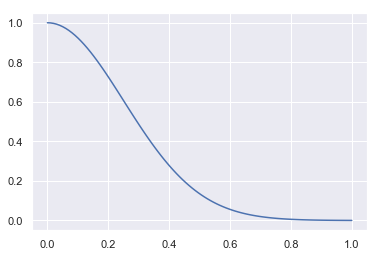

In [2]:
def rbf(X, x, var, l):
      return var*np.exp(-(abs(X-x)*abs(X-x))/(2*math.pow(l, 2)))

xmin = 0
xmax = 1
xx = np.linspace(xmin, xmax, 100)[:,None]
sns.lineplot(x=xx[:,0], y = rbf(xx, 0, 1, 0.25)[:,0])

Having concluded a value of $l$ that makes sense, we now put a distribution over it with mean around the chosen value and a variance representing our certainty. I am not too certain in my belief, and believe that $l$ could take on values quite a bit bigger than the mean value. Since the length scale is strictly positive I've chosen a gamma distribution, which it can be seen in the plot below. This is our length scale prior!

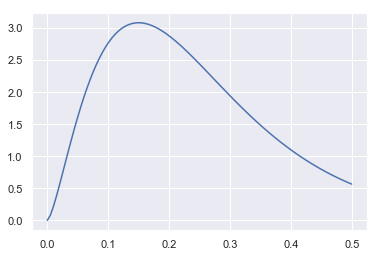

In [3]:
xmin = 0
xmax = 0.5
l_alpha = 2.5
l_theta = 0.1
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=l_alpha, scale=l_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Kernel Variance ($\sigma_f$)
The kernel variance determines the average distance that the function output has from the function mean. Since the output of the function is on $[0, 1]$, the output should not need to vary more than this. To prevent overfitting a $\sigma_f = 0.6$ seems right, but let's go with quite high uncertainty on this one. Since it is also a strictly positive quantity a gamma distribution is used here as well, like with the lengthscale.

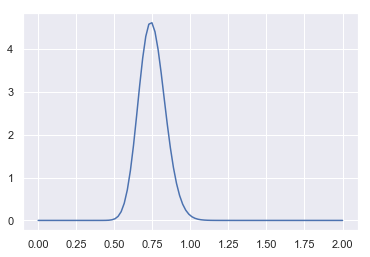

In [4]:
xmin = 0
xmax = 2
sigmaf_alpha = 75
sigmaf_theta = 0.01
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=sigmaf_alpha, scale=sigmaf_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Likelihood Variance ($\sigma$)
We also need to chose a prior for the likelihood variance $\sigma$, which representas the measurement noise. This model will assume a static variance, even though we know that it depends on where in the city you are. In mode dense areas the GPS accuracy suffers a bit while it works well in more rural areas. A seperate model for the GPS variance estimation should be used if this was done properly.

In the provided thesis the average GPS variance of a smartphone is claimed to be $\sigma = 10^-5$ so we'll go with that, but like with $\sigma_f$ we will be quite uncertain.

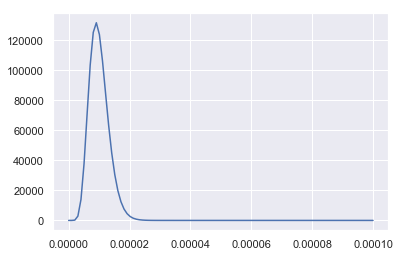

In [5]:
xmin = 0
xmax = 0.0001
sigma_alpha = 10
sigma_theta = 0.000001
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=sigma_alpha, scale=sigma_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

# Training
Alrighty, time to train a GP. The idea here is to train on a single trajectory that embodies what we want from the synchronisation. This works because the model is used to interpolation and has consequently no need to generalise. We use both the training and support data for this model, for reasons mentioned in notebook 1.

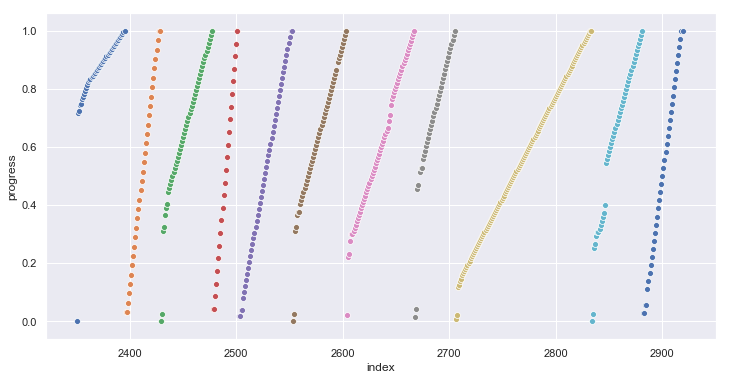

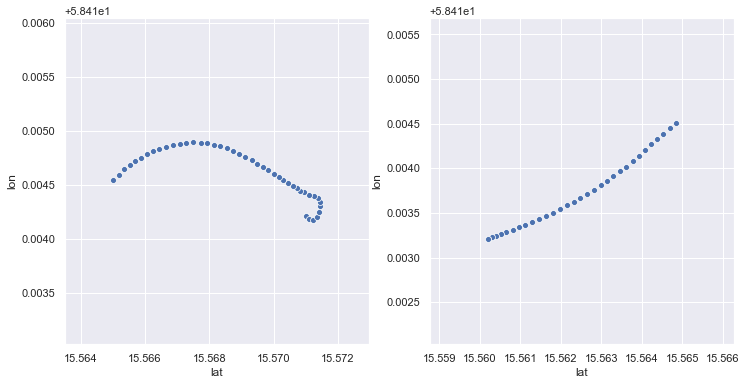

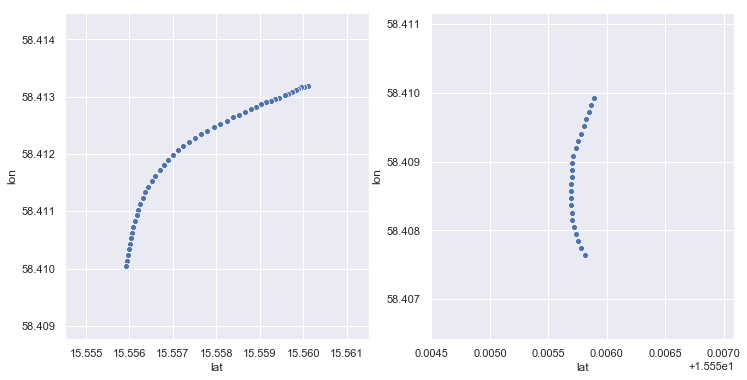

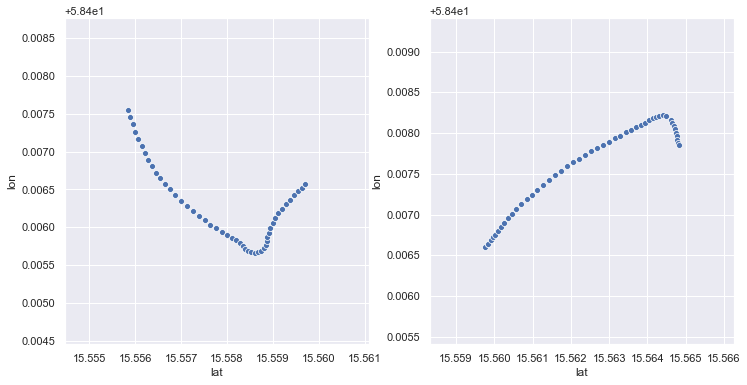

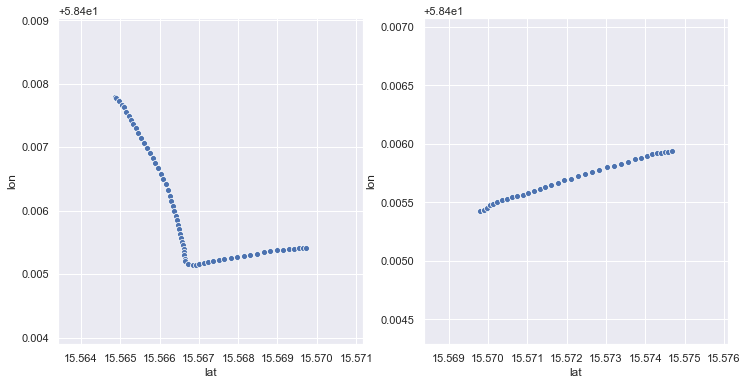

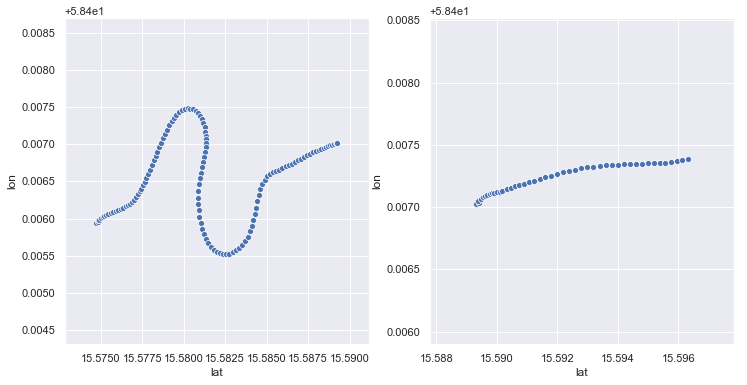

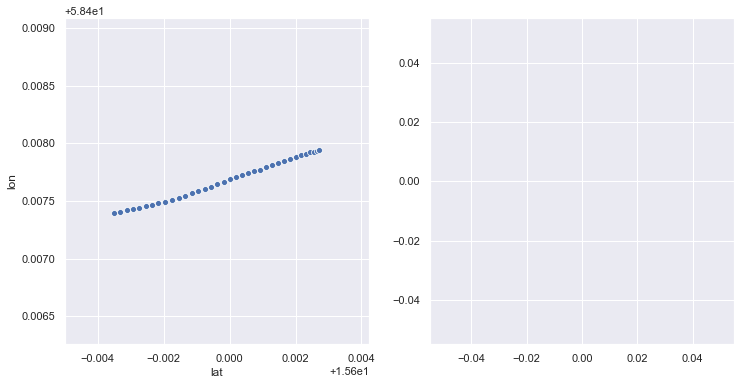

In [6]:
n_trajs = train.traj.unique()
traj_n = n_trajs[1] # 1: decent
#train = train.append(support)
traj = train[train.traj == traj_n]
plot.traj_progress(traj)
plot.traj_segment_grid(traj)

Having found a seg_n that seems typical we can now fit GPs for each of its segments. The plan was, as mentioned, to use the support data in addition to the regular data. However incorporating it has made the posterior uncomputable due to matrix singularity, so the regular training data i used for now.

In [8]:
def train_gp(data, route_n, traj_n, seg_n):
    seg = data[data.seg == seg_n]
    model = gp.build(seg, ['lat', 'lon'], ['progress'], 'synch', route_n, traj_n, seg_n)
    model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(0.8, 0.001))
    model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(0.6, 0.01))
    model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.1, 0.1))
    gp.train(model, 5)
    return model

np.random.seed(2)
n_segs = traj.seg.unique()
gps = [train_gp(traj, route_n, traj_n, seg_n) for seg_n in n_segs]

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -18.880398095465054
Optimization restart 2/5, f = -18.88039809619162
Optimization restart 3/5, f = -18.880398096191588
Optimization restart 4/5, f = -18.88039809616605
Optimization restart 5/5, f = -18.880398096191534
Optimization restart 1/5, f = -65.70306444123584
Optimization restart 2/5, f = -65.70306444123571
Optimization restart 3/5, f = -65.7030644411129
Optimization restart 4/5, f = -65.70306444123352
Optimization restart 5/5, f = -65.70306444123565
Optimization restart 1/5, f = -68.57662722862364


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -68.5766272263094
Optimization restart 3/5, f = -68.57662723138375
Optimization restart 4/5, f = -68.57662723144301
Optimization restart 5/5, f = -68.5766272314174
Optimization restart 1/5, f = -28.219960499341955
Optimization restart 2/5, f = 47216.313782788115
Optimization restart 3/5, f = -28.219960499343987
Optimization restart 4/5, f = -28.219960497747792
Optimization restart 5/5, f = -28.219960499346076
Optimization restart 1/5, f = -134.1800327713408
Optimization restart 2/5, f = -134.1800328462055


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -134.18003284616253
Optimization restart 4/5, f = -134.18003284334188
Optimization restart 5/5, f = -134.18003284039347
Optimization restart 1/5, f = -64.81257432889225
Optimization restart 2/5, f = -64.81257432880048
Optimization restart 3/5, f = -64.81257432889399
Optimization restart 4/5, f = -64.8125743280523
Optimization restart 5/5, f = -64.81257432889164
Optimization restart 1/5, f = -110.76257376206354
Optimization restart 2/5, f = -110.76257376211424
Optimization restart 3/5, f = -110.76257376197596


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -110.76257376199457
Optimization restart 5/5, f = -110.76257376211835
Optimization restart 1/5, f = -30.10911585685182
Optimization restart 2/5, f = 135738.82944756752
Optimization restart 3/5, f = -30.109115856850604
Optimization restart 4/5, f = 135738.1049014576
Optimization restart 5/5, f = -30.10911585677457


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -370.13528995894524
Optimization restart 2/5, f = -370.1352899590645
Optimization restart 3/5, f = -370.13528995813516
Optimization restart 4/5, f = 20084.98352700046
Optimization restart 5/5, f = -370.13528995909655
Optimization restart 1/5, f = -78.46164698360575


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -78.46164698329622
Optimization restart 3/5, f = -78.46164698361201
Optimization restart 4/5, f = -78.46164698354765
Optimization restart 5/5, f = -78.46164698075847
Optimization restart 1/5, f = -87.48050400469522
Optimization restart 2/5, f = -87.4805040046392
Optimization restart 3/5, f = -87.48050400468661
Optimization restart 4/5, f = -87.4805040046947
Optimization restart 5/5, f = -87.48050400470369


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\

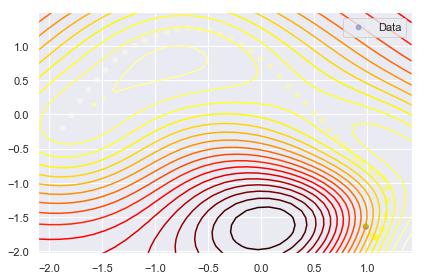

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


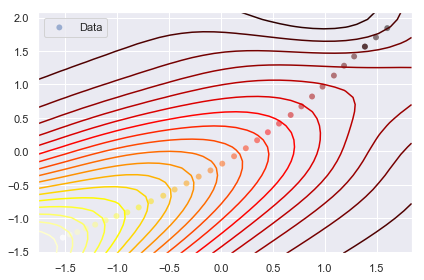

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


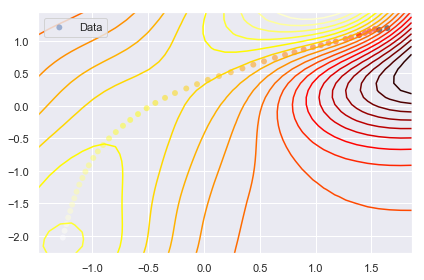

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


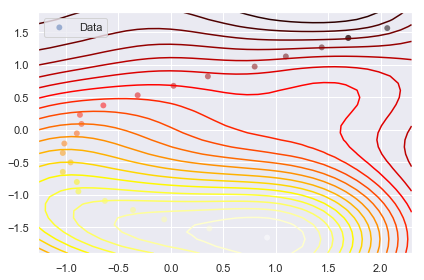

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


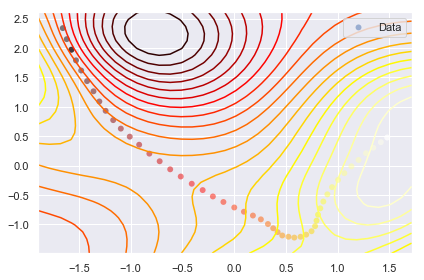

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


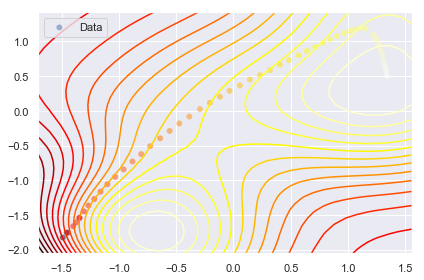

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


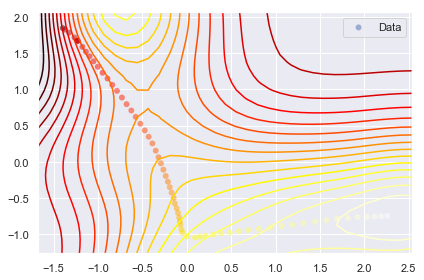

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


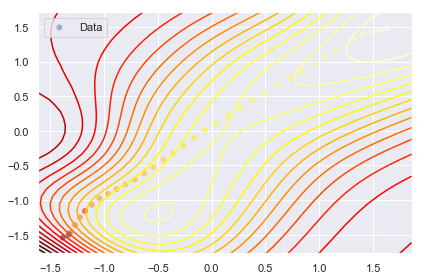

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


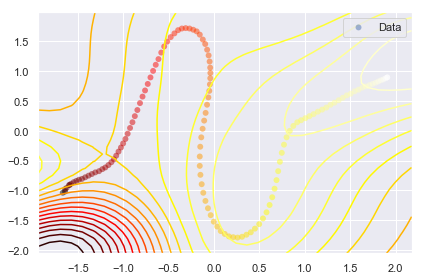

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


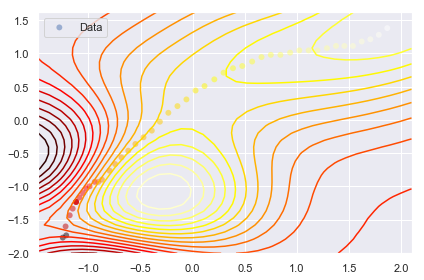

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


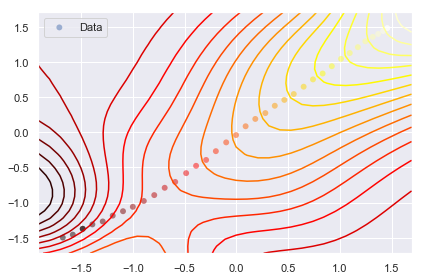

In [9]:
def plot_gps(gps):
    for model in gps:
        gp.plot(model)

plot_gps(gps)

It's really hard to get a model to fit all the routes. There are major problems in the start of each segment, which is most likely causesd by the fact that the buses stand still for quite some time and the slow travel speed when starting. A lot of these data points are filtered in preprocessing which may also have an impact on the result (hopefully it is positive though). Hopefully the plots above look pretty enough and we can store them for use in the prediction step.

In [10]:
n_segs = traj.seg.unique()
for synch_gp in gps:
     gp.save(synch_gp)   

A final test of the load functions and plotting of predictions

In [ ]:
from sklearn.preprocessing import scale

_fig, ax = plt.subplots(nrows=len(n_segs), ncols=1, figsize=(6, int(6*len(n_segs))))
for seg_n in n_segs:
    seg = traj[traj.seg == seg_n]
    sgp = gp.load(seg, ['lat', 'lon'], ['progress'], 'synch', route_n, traj_n, seg_n)
    X = scale(seg[['lat', 'lon']].values)
    mean, _var = gp.predict(sgp, X)
    df = pd.DataFrame({'pred': mean.T[0], 'X': range(X.shape[0])})
    sns.scatterplot(data=df, x='X', y='pred', ax=ax[int(seg_n)-1])